In [1]:
#%pip install kagglehub[pandas-datasets]
import kagglehub
import pandas as pd
import os

# Download latest version
path = kagglehub.dataset_download("emineyetm/fake-news-detection-datasets")
print("Path to dataset files:", path)

# The code above is from the Kaggle website where it gives a sample of how to download

'''
Step 1 of ML workflow: Reading in Dataset

'''

# joins path above with directory created
base_path = os.path.join(path, "News _dataset")

# reads cvs files
fake_df = pd.read_csv(os.path.join(base_path, "Fake.csv"))
true_df = pd.read_csv(os.path.join(base_path, "True.csv"))

# checking whether they loaded in correctly
display(fake_df.head())
display(true_df.head())

Path to dataset files: /Users/jaisumersandhu/.cache/kagglehub/datasets/emineyetm/fake-news-detection-datasets/versions/1


,title,text,subject,date
0,Donald Trump Sends Out Embarrassing New Year’...,Donald Trump just couldn t wish all Americans ...,News,"December 31, 2017"
1,Drunk Bragging Trump Staffer Started Russian ...,House Intelligence Committee Chairman Devin Nu...,News,"December 31, 2017"
2,Sheriff David Clarke Becomes An Internet Joke...,"On Friday, it was revealed that former Milwauk...",News,"December 30, 2017"
3,Trump Is So Obsessed He Even Has Obama’s Name...,"On Christmas day, Donald Trump announced that ...",News,"December 29, 2017"
4,Pope Francis Just Called Out Donald Trump Dur...,Pope Francis used his annual Christmas Day mes...,News,"December 25, 2017"


,title,text,subject,date
0,"As U.S. budget fight looms, Republicans flip t...",WASHINGTON (Reuters) - The head of a conservat...,politicsNews,"December 31, 2017"
1,U.S. military to accept transgender recruits o...,WASHINGTON (Reuters) - Transgender people will...,politicsNews,"December 29, 2017"
2,Senior U.S. Republican senator: 'Let Mr. Muell...,WASHINGTON (Reuters) - The special counsel inv...,politicsNews,"December 31, 2017"
3,FBI Russia probe helped by Australian diplomat...,WASHINGTON (Reuters) - Trump campaign adviser ...,politicsNews,"December 30, 2017"
4,Trump wants Postal Service to charge 'much mor...,SEATTLE/WASHINGTON (Reuters) - President Donal...,politicsNews,"December 29, 2017"


In [4]:
'''
Step 2 of the ML Workflow: Data processing

'''

# Checking to see whether there are any missing values
print("Missing values in fake news file:")
print(fake_df.isnull().sum())

print("\nMissing values in true news file:")
print(true_df.isnull().sum())\



# Checking to see if the same datatype is in each column
true_types_df = true_df.applymap(type)
fake_types_df = fake_df.applymap(type)

true_type_counts = true_types_df.nunique()
fake_type_counts = fake_types_df.nunique()

print("\nUnique datatypes in true news file: \n", true_type_counts)
print("\nUnique datatypes in fake news file: \n", fake_type_counts)


# As seen from the results below, each column has one type of datatype and 
# each column has no missing values


Missing values in fake news file:
title      0
text       0
subject    0
date       0
dtype: int64

Missing values in true news file:
title      0
text       0
subject    0
date       0
dtype: int64

Unique datatypes in true news file: 
 title      1
text       1
subject    1
date       1
dtype: int64

Unique datatypes in fake news file: 
 title      1
text       1
subject    1
date       1
dtype: int64


/var/folders/dc/2n0yjtjj5gj8sh2h0r9bvhy00000gn/T/ipykernel_93917/3258834345.py:16: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  true_types_df = true_df.applymap(type)
/var/folders/dc/2n0yjtjj5gj8sh2h0r9bvhy00000gn/T/ipykernel_93917/3258834345.py:17: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  fake_types_df = fake_df.applymap(type)


In [20]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.svm import LinearSVC

# Adding labels to fake and true news data, where fake = 1 and true = 0
fake_df['label'] = 1
true_df['label'] = 0

# Concatenating the fake and true news data and shuffling it
df = pd.concat([fake_df, true_df], ignore_index=True)
df = df.sample(frac=1, random_state=0).reset_index(drop=True)

# Combining the title and text columns to create a single input for the vectorizer
df['combined_title_and_text'] = df['title'] + " " + df['text']
X = df['combined_title_and_text']
y = df['label']

# Splitting the data into a 75% train and 25% test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=0)

# Creating a pipeline with a TF-IDF transformer and an SVM (LinearSVC) classifier
pipeline = Pipeline([
    ('tfidf', TfidfVectorizer(stop_words='english', max_df=0.6, max_features=1000)),
    ('svm', LinearSVC(random_state=0, C=0.001))
])

# Fitting the pipeline to the training data
pipeline.fit(X_train, y_train)

# Predicting labels for the test set
y_pred = pipeline.predict(X_test)

In [ ]:
from sklearn.model_selection import GridSearchCV

param_grid = {
    'tfidf__max_df': [0.6, 0.7],
    'tfidf__max_features': [500, 1000],
    'svm__C': [0.001, 0.01, 0.1]
}

grid = GridSearchCV(pipeline, param_grid, cv=5, scoring='accuracy', n_jobs=-1)
grid.fit(X_train, y_train)

print("Best parameters:", grid.best_params_)
print("Best cross-validation score:", grid.best_score_)
print("Test set score:", grid.score(X_test, y_test))
#Now we shall change the parameters so that the svm is more regularized

Accuracy: 0.936125
Precision: 0.934177
Recall: 0.942719
F1-Score: 0.938429
ROC-AUC: 0.935902
Precision-Recall AUC: 0.910243


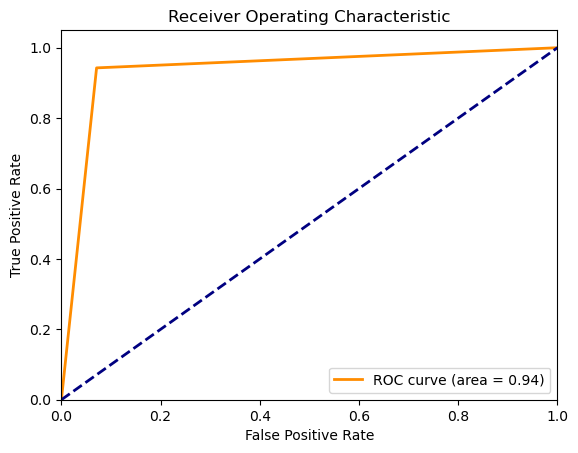

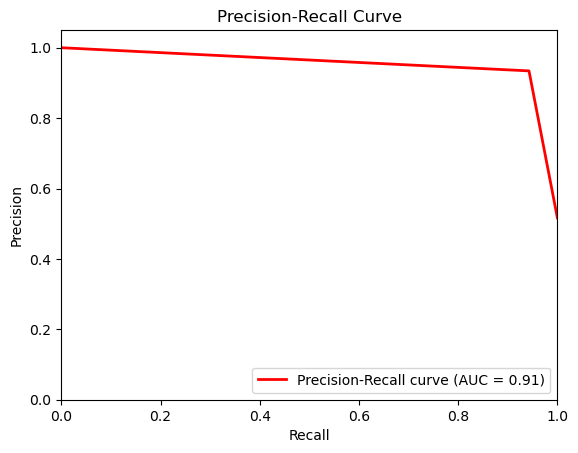

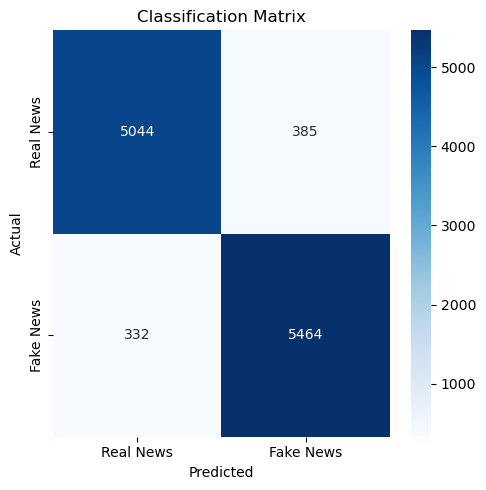

In [22]:
'''
Step 4 and 5 of the ML Workflow: Validation and Visualization of Results

Note: The code below is from "Validation Metrics Practice Sol'n" that is in D2L.

'''

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve, auc, precision_recall_curve, average_precision_score, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Calculate validation metrics
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_pred)
precision_recall_auc = average_precision_score(y_test, y_pred)

# Print the metrics
print(f"Accuracy: {accuracy:.6f}")
print(f"Precision: {precision:.6f}")
print(f"Recall: {recall:.6f}")
print(f"F1-Score: {f1:.6f}")
print(f"ROC-AUC: {roc_auc:.6f}")
print(f"Precision-Recall AUC: {precision_recall_auc:.6f}")

# Plot ROC curve
fpr, tpr, _ = roc_curve(y_test, y_pred)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc='lower right')
plt.show()


# Calculate precision-recall curve
precision, recall, _ = precision_recall_curve(y_test, y_pred)

# Plot precision-recall curve
plt.figure()
plt.plot(recall, precision, color='red', lw=2, label='Precision-Recall curve (AUC = %0.2f)' % precision_recall_auc)

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('Precision-Recall Curve')
plt.legend(loc='lower right')
plt.show()

# Create confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Set up the figure suize using subplots
fig, axes = plt.subplots(figsize=(5, 5))

# Create a heatmap
sns.heatmap(cm, xticklabels=['Real News', 'Fake News'],  yticklabels=['Real News', 'Fake News'],  annot=True, fmt='d', cmap='Blues', ax=axes)
axes.set_title('Classification Matrix')
axes.set_xlabel('Predicted')
axes.set_ylabel('Actual')

plt.tight_layout()
plt.show()